In [10]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.filters import gaussian_filter1d
import warnings
import cv2

warnings.filterwarnings(action='ignore')
%tensorflow_version 1.x
%matplotlib inline


def min_max_scaler(x):
    scaled_x = (x - x.min()) / (x.max() - x.min())
    return scaled_x


def max_abs_scaler(x):
    scaled_x = x / abs(x).max()
    return scaled_x

  
def macd(df, short=12, long=26, signal=9):
    df['MACD'] = df['close'].ewm(span=short, min_periods=short - 1, adjust=False).mean() - \
                 df['close'].ewm(span=long, min_periods=long - 1, adjust=False).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=signal, min_periods=signal - 1, adjust=False).mean()
    df['MACD_OSC'] = df.MACD - df.MACD_Signal
    df['MACD_Zero'] = 0

    return

    
gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/'

#           read reg ohlcv          #
file_path = gdrive_path + 'ohlcv/'
file_list = os.listdir(file_path)

2020-03-16 ELF ohlcv.xlsx
2020-03-16 CTXC ohlcv.xlsx
2020-03-16 DASH ohlcv.xlsx
2020-03-16 ENJ ohlcv.xlsx
2020-03-16 DVP ohlcv.xlsx
2020-03-16 EM ohlcv.xlsx
2020-03-16 DAD ohlcv.xlsx
2020-03-16 DAC ohlcv.xlsx
2020-03-16 EOS ohlcv.xlsx
2020-03-16 ETC ohlcv.xlsx
2020-03-16 GXC ohlcv.xlsx
2020-03-16 FAB ohlcv.xlsx
2020-03-16 FNB ohlcv.xlsx
2020-03-16 ETZ ohlcv.xlsx
2020-03-16 FCT ohlcv.xlsx
2020-03-16 FZZ ohlcv.xlsx
2020-03-16 FX ohlcv.xlsx
2020-03-16 GNT ohlcv.xlsx
2020-03-16 ETH ohlcv.xlsx
2020-03-16 HC ohlcv.xlsx
2020-03-16 HDAC ohlcv.xlsx
2020-03-16 HYC ohlcv.xlsx
2020-03-16 ICX ohlcv.xlsx
2020-03-16 IOST ohlcv.xlsx
2020-03-16 IPX ohlcv.xlsx
2020-03-16 INS ohlcv.xlsx
2020-03-16 LINK ohlcv.xlsx
2020-03-16 ITC ohlcv.xlsx
2020-03-16 LAMB ohlcv.xlsx
2020-03-16 LBA ohlcv.xlsx
2020-03-16 KNC ohlcv.xlsx
2020-03-16 LOOM ohlcv.xlsx
2020-03-16 LRC ohlcv.xlsx
2020-03-16 OGO ohlcv.xlsx
2020-03-16 MCO ohlcv.xlsx
2020-03-16 LTC ohlcv.xlsx
2020-03-16 LUNA ohlcv.xlsx
2020-03-16 MBL ohlcv.xlsx
2020-03

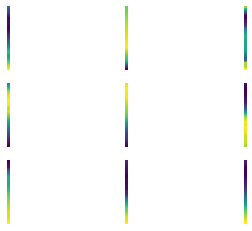

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 30, 1, 1)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 1, 128)        1280      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 1, 128)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 1, 64)         73792     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30, 1, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 1, 32)         18464     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 30, 1, 32)         0   

In [12]:
input_data_length = 30
pixel_width = 100
model_num = 108

short, long, signal = 105, 168, 32
sigma= 10
pull_range = 0
inverse = 0

# print(file_list)
# breakpoint

dataX, dataY = list(), list()
for i in range(len(file_list)):

  if i > 100:
    break

  file = file_list[i]
  print(file)
  # breakpoint

  ohlcv_reg = pd.read_excel(file_path + file, index_col=0)
  macd(ohlcv_reg, short=short, long=long, signal=signal)
  # plt.plot(ohlcv_reg.iloc[:, [-2]])
  # macd(ohlcv_reg, short=150, long=300, signal=50)
  # plt.plot(ohlcv_reg.iloc[:, [-2]])
  # plt.show()
  # breakpoint

  ohlcv_reg['osc_reg'] = gaussian_filter1d(ohlcv_reg['close'], sigma=sigma)
  ohlcv_reg['osc_reg'] = ohlcv_reg['osc_reg'].shift(-pull_range)
  # print(ohlcv_reg.tail(20))
  # breakpoint

  #     X_data : idl 만큼의 close? (일단),    Y_data : reg
  #     실시간으로 reg의 형태가 machine learning으로는 고정되지 않기 때문에,
  #     먼저 고정을 시키고, deep learning을 이용해 실시간으로 고정된 regression 결과를 뽑아낼 수 있는지 확인한다.
  #     충분히 가능성 있다.     #

  #         reg_target = close인 경우 앞의 데이터가 산다.       #  close/ close_reg
  if pull_range != 0:
    ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.MACD_Signal.isna())-pull_range:-pull_range, :] # 
    # ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.osc_reg.isna())-pull_range:-pull_range, :] # 
  else:
    ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.MACD_Signal.isna()):, :] # 
    # ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.osc_reg.isna()):, :] # 

  reg_target = ohlcv_reg[:, [-3]].astype(np.float32)

  #       Y_value Labeling    #
  reg_result = [np.nan] * len(reg_target)
  for i in range(1, len(reg_result)):
    if ohlcv_reg[:, [-1]][i - 1] < ohlcv_reg[:, [-1]][i]:
      reg_result[i] = 1
      # reg_result[i] = 'up'
    else:
      reg_result[i] = 0
      # reg_result[i] = 'down'

  # for i in range(1, len(reg_result)):
  #   if reg_result[i - 1] == 'down' and reg_result[i] == 'up':
  #     reg_result[i] = 1
  #   elif reg_result[i - 1] == 'up' and reg_result[i] == 'down':
  #     reg_result[i] = 2
  # for i in range(len(reg_result)):
  #   if not reg_result[i] in [1, 2]:
  #     reg_result[i] = 0 

  num_classes = 2

  # print(reg_result)
  # breakpoint
  # reg_result = ohlcv_reg[:, [-1]].astype(np.float32)
  # print(np.sum(np.isnan(reg_target)))
  # print(np.sum(np.isnan(reg_result)))
  # breakpoint
  # plt.plot(reg_target)
  # plt.plot(reg_result)
  # plt.show()
  # breakpoint

  if len(reg_target) == 0:
    continue
  # reg_target_0 = ohlcv_reg[:, -5:-1].astype(np.float32)


  scaler_x = StandardScaler()
  # scaler_y = StandardScaler()
  reg_target = scaler_x.fit_transform(reg_target)
  # reg_result = scaler_y.fit_transform(reg_result)
  # reg_target = max_abs_scaler(reg_target)
  # reg_target_0 = max_abs_scaler(reg_target_0)
  # reg_target = np.hstack((reg_target_0, reg_target))

  # reg_result = max_abs_scaler(reg_result)
  # print(reg_target, reg_result)
  # breakpoint

  # dataX, dataY = list(), list()
  for i in range(input_data_length, len(reg_target)):

    # group_x = reg_target[i - input_data_length: i]
    group_x = reg_target[i + 1 - input_data_length: i + 1]
    # group_x = cv2.resize(group_x.reshape(-1, group_x.shape[1], 1), (pixel_width, pixel_width))
    group_y = reg_result[i]
    # print(group_x[0])
    # quit()

    #   데이터 값에 결측치가 존재하는 경우 #
    if sum(sum(np.isnan(group_x))) > 0:
        continue

    if inverse == 1:
        dataX.append(group_x[::-1])  # dataX 리스트에 추가 [::-1]
    else:
        dataX.append(group_x)  # dataX 리스트에 추가 [::-1]
    dataY.append(group_y)

Made_X = np.array(dataX)
Made_X = np.array(dataX).reshape(-1, Made_X.shape[1], Made_X.shape[2], 1)
Made_Y = np.array(dataY)

# Data Class Weight
from sklearn.utils import class_weight

# print(Y_train[:, 0])
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(Made_Y),
                                                  Made_Y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

from keras.utils import np_utils
Made_Y = np_utils.to_categorical(Made_Y, num_classes)

# Made_X = np.array(reg_target)
# Made_Y = np.array(reg_result)
# print(Made_X.shape, Made_Y.shape)
# breakpoint  

# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(Made_X, Made_Y, test_size=0.4,
#                                                    shuffle=False)
# X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5,
#                                                    shuffle=False)

#     DATA CONTINOUS SPLIT    #
total_len = len(Made_X)
train_len = int(0.4 * total_len)
val_len = int(0.7 * total_len)

X_train = Made_X[:train_len]
X_val = Made_X[train_len:val_len]
X_test = Made_X[val_len:]
Y_train = Made_Y[:train_len]
Y_val = Made_Y[train_len:val_len]
Y_test = Made_Y[val_len:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)
# breakpoint

row = X_train.shape[1]
col = X_train.shape[2]

from keras.preprocessing.image import ImageDataGenerator 

datagen = ImageDataGenerator( 
#     rotation_range = 60,
#     zoom_range = 0.6,
#     shear_range = 0.6,
#     horizontal_flip = True,
#     width_shift_range=0.6,
#     height_shift_range=0.6,
    fill_mode = 'nearest'
    )

testgen = ImageDataGenerator( 
    )
datagen.fit(X_train)
batch_size = 32

for X_batch, _ in datagen.flow(X_train, Y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(row, col))
    plt.axis('off') 
    plt.show() 
    break
# breakpoint
    
train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, Y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, Y_test, batch_size=batch_size) 

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.layers import Dense, LSTM, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf

class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Gelu(gelu)})


def FER_Model(input_shape=(row, col, 1)):

    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(128, kernel_size=3, padding='same')(visible)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_1 = net

    net = layers.Conv2D(64, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

    net = layers.Conv2D(32, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs =visible, outputs = net)
    # summary layers
    model.summary()

    return model

model = FER_Model()
# from keras.models import load_model
# model = load_model(gdrive_path + 'model/rapid_ascending %s_%s_ohlc.hdf5' % (input_data_length, model_num))

# opt = RMSprop(lr=0.05, rho=0.9,epsilon=1e-10)
opt = Adam(lr=0.0001, decay=1e-6)
# opt = Adadelta(lr=1., rho=0.95, epsilon=1e-13)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  
    
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath = gdrive_path + "model/rapid_ascending %s_%s_ohlc.hdf5" % (input_data_length, model_num)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=30)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 200
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size,
                    shuffle=False)


(1124.0, 1624.0)

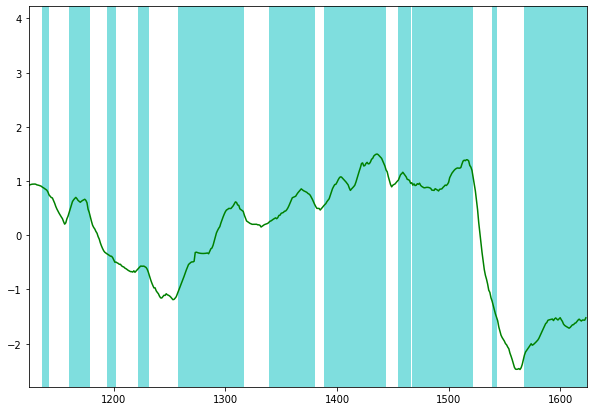

In [0]:
pred_reg = model.predict(X_test)
# Y_pred = Made_Y.copy()
Y_pred = np.argmax(Made_Y.copy(), axis=1)
# Y_pred[val_len:] = pred_reg
Y_pred[val_len:] = np.argmax(pred_reg, axis=1)
Y_label = np.argmax(Made_Y, axis=1)
# print(Y_pred)
# print(Y_label)
# breakpoint

span_list = list()
span_list_y = list()
for i in range(val_len, len(Y_pred)):
    if Y_pred[i] == 1:
      span_list.append((i, i + 1))
    if Y_label[i] == 1:
      span_list_y.append((i, i + 1))

plt.figure(figsize=(10, 7))
# plt.subplot(311)
if inverse == 1:
    plt.plot(Made_X[:, [0], [-1]].reshape(-1, 1), color='g', label='MACD_OSC') #   if [::-1], [0]
else:
    plt.plot(Made_X[:, [-1], [-1]].reshape(-1, 1), color='g', label='MACD_OSC')
# plt.plot(Made_Y[:, [-1]], color='r', label='Gaussian')
# plt.plot(Y_pred[:, [-1]], color='b', label='Gaussian Pred')
# plt.axvline(x=val_len)
# for i in range(len(span_list)):
#     plt.axvspan(span_list[i][0], span_list[i][1], facecolor='y', alpha=0.5)

# plt.title('Gaussian_PRED', color='white')
# plt.legend(loc='upper right')

# plt.subplot(312)
# plt.plot(Y_pred[:, [-1]], color='r', label='Gaussian Pred')
for i in range(len(span_list)):
    plt.axvspan(span_list[i][0], span_list[i][1], facecolor='c', alpha=0.5)
# plt.xlim(val_len, len(Y_pred))

# plt.subplot(313)
# plt.plot(Made_Y[:, [-1]], color='b', label='Gaussian')
# for i in range(len(span_list)):
#     plt.axvspan(span_list[i][0], span_list[i][1], facecolor='y', alpha=0.5)
# for i in range(len(span_list_y)):
#     plt.axvspan(span_list_y[i][0], span_list_y[i][1], facecolor='m', alpha=0.5)
plt.xlim(len(Y_pred) - 500, len(Y_pred))

# plt.show()


2019-10-14 TRX ohlcv.xlsx


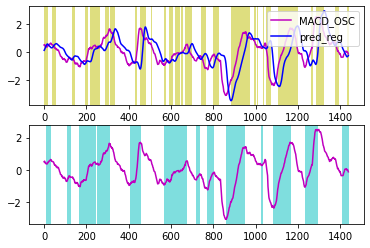

In [0]:
file = file_list[3]
print(file)
inverse = 0

ohlcv_reg = pd.read_excel(file_path + file, index_col=0)
macd(ohlcv_reg, short=short, long=long, signal=signal)
ohlcv_reg['osc_reg'] = gaussian_filter1d(ohlcv_reg['MACD_OSC'], sigma=10)
# print(ohlcv_reg.iloc[:, [-1]])
# breakpoint

#     X_data : idl 만큼의 close? (일단),    Y_data : reg
#     실시간으로 reg의 형태가 machine learning으로는 고정되지 않기 때문에,
#     먼저 고정을 시키고, deep learning을 이용해 실시간으로 고정된 regression 결과를 뽑아낼 수 있는지 확인한다.
#     충분히 가능성 있다.     #

#         reg_target = close인 경우 앞의 데이터가 산다.       #  close/ close_reg
ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.osc_reg.isna()):, :]
reg_target = ohlcv_reg[:, [-3]].astype(np.float32)
reg_result = ohlcv_reg[:, [-1]].astype(np.float32)
# print(reg_result)
# print(np.sum(np.isnan(reg_target)))
# print(np.sum(np.isnan(reg_result)))
# breakpoint

scaler_x = StandardScaler()
scaler_y = StandardScaler()
reg_target = scaler_x.fit_transform(reg_target)
reg_result = scaler_y.fit_transform(reg_result)
# reg_target = max_abs_scaler(reg_target)
# reg_result = max_abs_scaler(reg_result)
# print(reg_target, reg_result)
# breakpoint

dataX, dataY = list(), list()
for i in range(input_data_length, len(reg_target)):

  # group_x = reg_target[i - input_data_length: i]
  # group_x = reg_target[i + 1 - input_data_length: i + 1]
  group_x = gaussian_filter1d(reg_target[i + 1 - input_data_length: i + 1], sigma=sigma)
  group_y = reg_result[i]
  # print(group_x[0])
  # quit()

  #   데이터 값에 결측치가 존재하는 경우 #
  if sum(sum(np.isnan(group_x))) > 0:
      continue

  if inverse == 1:
    dataX.append(group_x[::-1])  # dataX 리스트에 추가
  else:
    dataX.append(group_x)
  dataY.append(group_y)

Made_X = np.array(dataX)
Made_Y = np.array(dataY)

# Made_X = np.array(reg_target)
# Made_Y = np.array(reg_result)

# from keras.models import load_model
# model = load_model(gdrive_path + 'model/rapid_ascending %s_%s_ohlc.hdf5' % (input_data_length, model_num))

pred_reg = model.predict(X_test)
# Y_pred = Made_Y.copy()
Y_pred = np.argmax(Made_Y.copy(), axis=1)
# Y_pred[val_len:] = pred_reg
Y_pred[val_len:] = np.argmax(pred_reg, axis=1)
Y_label = np.argmax(Made_Y, axis=1)
# print(Y_pred)
# print(Y_label)
# breakpoint

span_list = list()
span_list_y = list()
for i in range(val_len, len(Y_pred)):
    if Y_pred[i] == 1:
      span_list.append((i, i + 1))
    if Y_pred[i] == 2: 
      span_list_y.append((i, i + 1))

plt.figure(figsize=(10, 7))
# plt.subplot(311)
if inverse == 1:
    plt.plot(Made_X[:, [0], [-1]].reshape(-1, 1), color='g', label='MACD_OSC') #   if [::-1], [0]
else:
    plt.plot(Made_X[:, [-1], [-1]].reshape(-1, 1), color='g', label='MACD_OSC')
# plt.plot(Made_Y[:, [-1]], color='r', label='Gaussian')
# plt.plot(Y_pred[:, [-1]], color='b', label='Gaussian Pred')
# plt.axvline(x=val_len)
# for i in range(len(span_list)):
#     plt.axvspan(span_list[i][0], span_list[i][1], facecolor='y', alpha=0.5)

# plt.title('Gaussian_PRED', color='white')
# plt.legend(loc='upper right')

# plt.subplot(312)
# plt.plot(Y_pred[:, [-1]], color='r', label='Gaussian Pred')
for i in range(len(span_list)):
    plt.axvspan(span_list[i][0], span_list[i][1], facecolor='c', alpha=0.5)
# plt.xlim(val_len, len(Y_pred))

# plt.subplot(313)
# plt.plot(Made_Y[:, [-1]], color='b', label='Gaussian')
# for i in range(len(span_list)):
#     plt.axvspan(span_list[i][0], span_list[i][1], facecolor='y', alpha=0.5)
for i in range(len(span_list_y)):
    plt.axvspan(span_list_y[i][0], span_list_y[i][1], facecolor='m', alpha=0.5)
plt.xlim(val_len, len(Y_pred))

# plt.show()